In [12]:
from BMI_HBVmountain_Python import *
import netCDF4 as nc


## Load forcing and observation data

In [13]:
grdc = pd.read_csv('Data/BigCreek/4118220_Q_Day.csv', sep=';', index_col=[0])
grdc.rename(columns={' Value':'streamflow'}, inplace=True)
pd.to_datetime(grdc.index);
forcing = grdc.loc["1-1-1985":"31-12-2005"]

forcing['streamflow'] = forcing['streamflow'] / 59311000 * 1000 *86400 #area * convertion mm * convertion /day
forcing = forcing.reset_index(level=0)

for i in range(len(forcing)):
    forcing['Date'][i] = datetime.datetime.strptime(forcing['Date'][i], '%d-%m-%Y')
    forcing['Date'][i] = forcing['Date'][i].date()
forcing.set_index('Date', inplace=True)

C:\Users\Vincent Hoogelander\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Vincent Hoogelander\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Vincent Hoogelander\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [14]:
path = 'Data/BigCreek/HBVmountain_REGEN_BigCreek_1985_2005.nc'
dsregen = nc.Dataset(path)

regen = (dsregen['pr'][:])*86400

preclist = []
for i in range(len(regen)):
    preclist.append(regen[i])


forcing['prec_REGEN'] = np.float64(preclist)


In [15]:
path = 'Data/BigCreek/HBVmountain_CRU_BigCreek_1985_2005.nc'
dscru = nc.Dataset(path)


monthly_data = forcing.groupby(pd.PeriodIndex(forcing.index, freq="M"))['prec_REGEN'].mean()
monthly_data.index = monthly_data.index.to_timestamp()

temp = (dscru['tas'][:])

tlist = []
for i in range(len(temp)):
    tlist.append(temp[i])

df_tlist = pd.DataFrame(tlist)
df_tlist.index = monthly_data.index

# df_tlist.index = df_tlist.index.to_timestamp()


start_date = forcing.index.min() 
end_date = forcing.index[-1]

dates = pd.date_range(start_date, end_date, freq='D')
dates.name = 'date'
df_tlist = df_tlist.reindex(dates, method='ffill')

forcing['monthly_temp_cru'] = df_tlist.values -273


In [1]:
forcing.prec_REGEN.mean()

NameError: name 'forcing' is not defined

## Setting up the model

In [17]:
model = BMI_HBVmountain()

In [18]:
config_file = model.setup()

In [19]:
model.initialize(config_file)

### Parameters

In [20]:
bare_parameters, forest_parameters, grass_parameters, rip_parameters,  slow_parameters, parameters_array =  Main.parameter_selection()
model.set_value('bare_parameters', bare_parameters)
model.set_value('forest_parameters', forest_parameters)
model.set_value('grass_parameters', grass_parameters)
model.set_value('rip_parameters', rip_parameters)
model.set_value('slow_parameters', slow_parameters)




In [ ]:

model.set_value('bare_parameters', bare_parameters)
model.set_value('forest_parameters', params_list[38][1])
model.set_value('grass_parameters', params_list[38][2])
model.set_value('rip_parameters', params_list[38][3])
model.set_value('slow_parameters', params_list[38][4])


#     beta:: Float64
#     Ce:: Float64
#     Drainagecapacity:: Float64 #only necessary for riparian HRU
#     Interceptionstoragecapacity:: Float64
#     Kf:: Float64
#     Meltfactor:: Float64
#     Mm:: Float64
#     #Percolationcapacity:: Float64 #only necessary for hillslope HRU
#     Ratio_Pref:: Float64 #only necessary for hillslope HRU
#     Soilstoragecapacity:: Float64
#     Temp_Thresh:: Float64

### Forcings

In [21]:
model.set_value('Temperature', (forcing['monthly_temp_cru'].values).reshape(len(forcing),1))
model.set_value('Precipitation', (forcing['prec_REGEN'].values).reshape(len(forcing),1))


model.set_value('Date', list(forcing.index.values))
model.set_value('Current_Date', forcing.index.values[0])

### Initial settings

In [22]:
model.set_value('Elevation', Main.Elevations(270, 1250, 2600, 1250, 1250))

model.set_value('Glacier', [0.0, 0.0, 0.0, 0.0])
model.set_value('Sunhours', [10.18, 10.90, 12.0, 13.10, 14.0, 14.45, 14.08, 13.31, 12.24, 11.25, 10.31, 9.85])
model.set_value('bare_input', Main.HRU_Input([0,0,0,0], 0, np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.2, np.zeros(4), 0, 0.0))
model.set_value('forest_input', Main.HRU_Input([0.0,0.20,0.73,0.07], 0.64,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.2, np.zeros(4), 0, 0.0))
model.set_value('grass_input', Main.HRU_Input([0.1,0.8,0.1,0.0], 0.35,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.2, np.zeros(4), 0, 0.0))
model.set_value('rip_input', Main.HRU_Input([1.0,0,0,0], 0.01,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.2, np.zeros(4), 0, 0.0))
model.set_value('Total_Elevationbands', 4)
model.set_value('Elevation_Percentage', [0.16,0.46,0.33,0.05])
model.set_value('bare_storage', Main.Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))
model.set_value('forest_storage', Main.Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))
model.set_value('grass_storage', Main.Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))
model.set_value('rip_storage', Main.Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))

## Running the model

In [23]:
Discharge = []
timestamp = []
while (model.get_value_ptr('Current_Date') < (datetime.date(1990, 1, 1))):  
    model.update()
    timestamp.append(model.get_value_ptr('Current_Date'))
    Discharge.append(model.get_value_ptr('Discharge'))

## Analysis

In [24]:
simulated_discharge_df = pd.DataFrame(
    {'simulation': Discharge},
    index=pd.to_datetime(timestamp)
)
combined_discharge = pd.merge(simulated_discharge_df, forcing['streamflow'], left_index=True, right_index=True)
combined_discharge

,simulation,streamflow
1985-01-02,0.016729,0.333591
1985-01-03,0.010724,0.326307
1985-01-04,0.006874,0.321937
1985-01-05,0.004406,0.321937
1985-01-06,0.002824,0.321937
...,...,...
1989-12-28,0.000711,0.090317
1989-12-29,0.000688,0.094687
1989-12-30,0.006509,0.090317
1989-12-31,0.004464,0.078663


(0, 2)

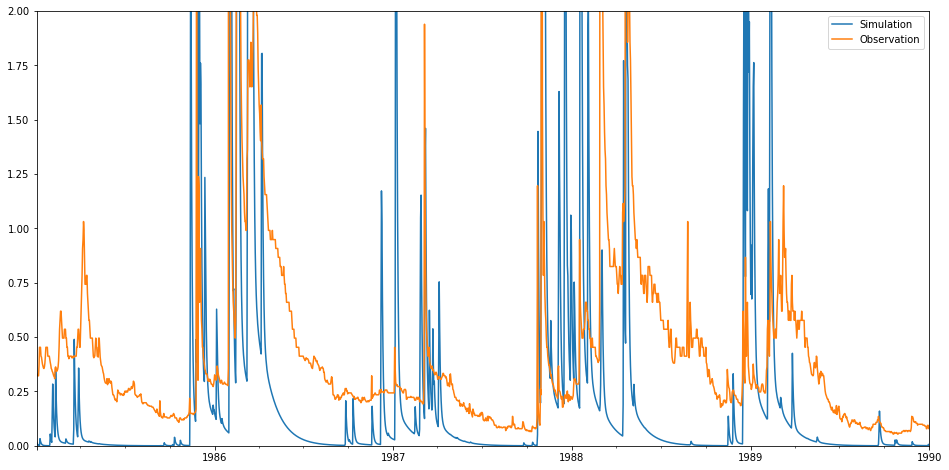

In [25]:
plt.figure(figsize=[16,8])
combined_discharge.simulation.plot(label='Simulation')
combined_discharge.streamflow.plot(label='Observation')
plt.legend();
# plt.figure(figsize=[16,8])
# plt.plot(forcing.prec_REGEN.values[0:1000], label='prec')
# plt.ylim(0,2)

In [28]:
def NSE(Qmodelled, Qobserved):    
    QobservedAverage = np.ones(len(Qobserved)) * np.mean(Qobserved)
    Nominator = np.sum((Qmodelled - Qobserved)**2)
    Denominator = np.sum((Qobserved - QobservedAverage)**2)
    NashSutcliffe = 1 - (Nominator / Denominator)
    return NashSutcliffe

In [79]:
nse = NSE(combined_discharge['simulation'].values, combined_discharge['streamflow'].values)
print(f'NSE = {nse}')

NSE = 0.3896270118896126


## Clean up

In [ ]:
model.finalize()

In [1]:
print(model)

NameError: name 'model' is not defined

## Calibration


In [29]:
NSElist = []
params_list = []

for i in range(5):
    model = BMI_HBVmountain()

    config_file = model.setup()

    model.initialize(config_file)

    bare_parameters, forest_parameters, grass_parameters, rip_parameters,  slow_parameters, parameters_array =  Main.parameter_selection()
    model.set_value('bare_parameters', bare_parameters)
    model.set_value('forest_parameters', forest_parameters)
    model.set_value('grass_parameters', grass_parameters)
    model.set_value('rip_parameters', rip_parameters)
    model.set_value('slow_parameters', slow_parameters)

    model.set_value('Temperature', (forcing['monthly_temp_cru'].values).reshape(len(forcing),1))
    model.set_value('Precipitation', (forcing['prec_REGEN'].values).reshape(len(forcing),1))

    model.set_value('Date', list(forcing.index.values))
    model.set_value('Current_Date', forcing.index.values[0])
    
    model.set_value('Elevation', Main.Elevations(270, 1250, 2600, 1250, 1250))
    model.set_value('Glacier', [0.0, 0.0, 0.0, 0.0])
    model.set_value('Sunhours', [10.18, 10.90, 12.0, 13.10, 14.0, 14.45, 14.08, 13.31, 12.24, 11.25, 10.31, 9.85])
    model.set_value('bare_input', Main.HRU_Input([0,0,0,0], 0, np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.2, np.zeros(4), 0, 0.0))
    model.set_value('forest_input', Main.HRU_Input([0.0,0.20,0.73,0.07], 0.64,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.2, np.zeros(4), 0, 0.0))
    model.set_value('grass_input', Main.HRU_Input([0.1,0.8,0.1,0.0], 0.35,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.2, np.zeros(4), 0, 0.0))
    model.set_value('rip_input', Main.HRU_Input([1.0,0,0,0], 0.01,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.2, np.zeros(4), 0, 0.0))
    model.set_value('Total_Elevationbands', 4)
    model.set_value('Elevation_Percentage', [0.16,0.46,0.33,0.05])
    model.set_value('bare_storage', Main.Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))
    model.set_value('forest_storage', Main.Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))
    model.set_value('grass_storage', Main.Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))
    model.set_value('rip_storage', Main.Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))

    Discharge = []
    timestamp = []
    while (model.get_value_ptr('Current_Date') < (datetime.date(1996, 1, 1))):  
        model.update()
        timestamp.append(model.get_value_ptr('Current_Date'))
        Discharge.append(model.get_value_ptr('Discharge'))

    simulated_discharge_df = pd.DataFrame(
        {'simulation': Discharge},
        index=pd.to_datetime(timestamp)
    )
    combined_discharge = pd.merge(simulated_discharge_df, forcing['streamflow'], left_index=True, right_index=True)

    nse = NSE(combined_discharge['simulation'].values[1100:-1], combined_discharge['streamflow'].values[1100:-1])
    NSElist.append(nse)
    params_list.append([bare_parameters, forest_parameters, grass_parameters, rip_parameters,  slow_parameters])

In [52]:
# pd.DataFrame({'NSE': NSElist, 'param_set': params_list[0][0]}) # 'param_set': params_list
params_list[0][0].beta

df = pd.DataFrame(columns=['NSE', 'beta', 'Ce', 'Drainagecapacity', 'Interceptionstoragecapacity',
                          'Kf', 'Meltfactor', 'Mm', 'Ratio_Pref', 'Soilstoragecapacity', 'Temp_Thresh'])
# params_list[28][0]

In [68]:
bare_paramset = pd.DataFrame(columns=['NSE', 'beta', 'Ce', 'Drainagecapacity', 'Interceptionstoragecapacity',
                          'Kf', 'Meltfactor', 'Mm', 'Ratio_Pref', 'Soilstoragecapacity', 'Temp_Thresh'])
forest_paramset = pd.DataFrame(columns=['NSE', 'beta', 'Ce', 'Drainagecapacity', 'Interceptionstoragecapacity',
                          'Kf', 'Meltfactor', 'Mm', 'Ratio_Pref', 'Soilstoragecapacity', 'Temp_Thresh'])
grass_paramset = pd.DataFrame(columns=['NSE', 'beta', 'Ce', 'Drainagecapacity', 'Interceptionstoragecapacity',
                          'Kf', 'Meltfactor', 'Mm', 'Ratio_Pref', 'Soilstoragecapacity', 'Temp_Thresh'])
rip_paramset = pd.DataFrame(columns=['NSE', 'beta', 'Ce', 'Drainagecapacity', 'Interceptionstoragecapacity',
                          'Kf', 'Meltfactor', 'Mm', 'Ratio_Pref', 'Soilstoragecapacity', 'Temp_Thresh'])
slow_paramset = pd.DataFrame(columns=['NSE', 'Ks', 'Ratio_Riparian'])

for i in range(len(NSElist)):
    bare_paramset.loc[i] = [NSElist[i], params_list[i][0].beta, params_list[i][0].Ce, params_list[i][0].Drainagecapacity, params_list[i][0].Interceptionstoragecapacity,
                                 params_list[i][0].Kf, params_list[i][0].Meltfactor, params_list[i][0].Mm, params_list[i][0].Ratio_Pref, params_list[i][0].Soilstoragecapacity,
                                params_list[i][0].Temp_Thresh]
    forest_paramset.loc[i] = [NSElist[i], params_list[i][1].beta, params_list[i][1].Ce, params_list[i][1].Drainagecapacity, params_list[i][1].Interceptionstoragecapacity,
                                 params_list[i][1].Kf, params_list[i][1].Meltfactor, params_list[i][1].Mm, params_list[i][1].Ratio_Pref, params_list[i][1].Soilstoragecapacity,
                                params_list[i][1].Temp_Thresh]
    grass_paramset.loc[i] = [NSElist[i], params_list[i][2].beta, params_list[i][2].Ce, params_list[i][2].Drainagecapacity, params_list[i][2].Interceptionstoragecapacity,
                                 params_list[i][2].Kf, params_list[i][2].Meltfactor, params_list[i][0].Mm, params_list[i][2].Ratio_Pref, params_list[i][2].Soilstoragecapacity,
                                params_list[i][2].Temp_Thresh]
    rip_paramset.loc[i] = [NSElist[i], params_list[i][3].beta, params_list[i][3].Ce, params_list[i][3].Drainagecapacity, params_list[i][3].Interceptionstoragecapacity,
                                 params_list[i][3].Kf, params_list[i][3].Meltfactor, params_list[i][3].Mm, params_list[i][3].Ratio_Pref, params_list[i][3].Soilstoragecapacity,
                                params_list[i][3].Temp_Thresh]
    islow_paramset.loc[i] = [NSElist[i], params_list[i][4].Ks, params_list[i][4].Ratio_Riparian]
    

        

In [76]:
import os

bare_name = 'bare_paramsets.csv'
forest_name = 'forest_paramsets.csv'
grass_name = 'grass_paramsets.csv'
rip_name = 'rip_paramsets.csv'
slow_name = 'slow_paramsets.csv'

outdir = './output'
if not os.path.exists(outdir):
    os.mkdir(outdir)

bare_fullname = os.path.join(outdir, bare_name)
forest_fullname = os.path.join(outdir, forest_name) 
grass_fullname = os.path.join(outdir, grass_name) 
rip_fullname = os.path.join(outdir, rip_name) 
slow_fullname = os.path.join(outdir, slow_name) 


bare_paramset.to_csv(bare_fullname)
forest_paramset.to_csv(forest_fullname)
grass_paramset.to_csv(grass_fullname)
rip_paramset.to_csv(rip_fullname)
slow_paramset.to_csv(slow_fullname)

In [67]:
i = 1
bare_paramset.loc[i] = [NSElist[i], params_list[i][0].beta, params_list[i][0].Ce, params_list[i][0].Drainagecapacity, params_list[i][0].Interceptionstoragecapacity,
                                 params_list[i][0].Kf, params_list[i][0].Meltfactor, params_list[i][0].Mm, params_list[i][0].Ratio_Pref, params_list[i][0].Soilstoragecapacity,
                                params_list[i][0].Temp_Thresh]

In [64]:
params_list[i][0].beta


1.814